In [2]:
! pip install opencv-python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [4]:
import cv2 

In [5]:
clean_labels = pd.read_csv("../data/clean_labels.csv", header = None)
noisy_labels = pd.read_csv("../data/noisy_labels.csv", header = None)

In [71]:
print(clean_labels.value_counts()) #clean data is fairly balanced

3    5101
4    5090
1    5070
5    5049
6    5033
8    5022
9    4938
7    4921
2    4920
0    4856
dtype: int64


In [7]:
n_img = 50000
all_imgs = np.empty((n_img, 32, 32, 3))

for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    all_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [8]:
clean_imgs = all_imgs[:10000,:,:,:] #images with human-verified labels
noisy_imgs = all_imgs[10000:,:,:,:] #images with just noisy labels

In [151]:
(clean_labels == noisy_labels.iloc[:10000]).sum() #number of correct labels in first 10000

0    3968
dtype: int64

what each label is:

1-car
2-bird
3-cat
4-deer
5-dog
6-frog
7-horse
8-ship
9-truck

In [152]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Concatenate, Add, Input, Embedding, Softmax
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD

In [153]:
np.random.seed(20)
tf.random.set_seed(20)

In [154]:
# one hot label data
clean_labs = to_categorical(clean_labels,num_classes = 10)
noisy_labs = to_categorical(noisy_labels,num_classes = 10)

In [196]:
img_input = Input(shape=(32, 32, 3))
label_input = Input(shape=(10,))

b1 = Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(32, 32, 3))(img_input)
b1 = LeakyReLU(alpha=0.1)(b1)
b1 = MaxPooling2D((2, 2), padding='same')(b1)
b1 = Dropout(0.25)(b1)
b1 = Conv2D(64, (3, 3), activation='linear', padding='same')(b1)
b1 = LeakyReLU(alpha=0.1)(b1)
b1 = MaxPooling2D(pool_size=(2, 2), padding='same')(b1)
b1 = Dropout(0.25)(b1)
b1 = Conv2D(128, (3, 3), activation='linear', padding='same')(b1)
b1 = LeakyReLU(alpha=0.1)(b1)
b1 = MaxPooling2D(pool_size=(2, 2), padding='same')(b1)
b1 = Dropout(0.4)(b1)
b1 = Flatten()(b1)
b1 = Dense(128, activation='linear')(b1)
b1 = Model(inputs=img_input, outputs=b1)

    # Second branch
b2 = Dense(128, activation="linear")(label_input)
b2 = Model(inputs=label_input, outputs=b2)

combined = Concatenate()([b2.output,b1.output])
b_combined = Dense(64, activation="relu")(combined)
b_combined = Dropout(0.2)(b_combined)
b_combined = Dense(10, activation="softmax")(b_combined)

cleaner_model = Model(inputs = [label_input,img_input], outputs = b_combined, name = "label_cleaner")

In [215]:
# cleaning model construction
input_labels = Input(shape = (10,))
xl = Dense(128)(input_labels)

input_images = Input(shape = (32,32,3,)) #CNN on images
xi = Conv2D(32,(3,3),1,padding="same",activation = "relu")(input_images)
# xi = BatchNormalization()(xi)
xi = LeakyReLU(0.1)(xi)
xi = MaxPooling2D((2,2),padding="valid")(xi)
xi = Dropout(0.2)(xi)
xi = Conv2D(64,(3,3),1,padding="same",activation = "relu")(xi)
# xi = BatchNormalization()(xi)
xi = LeakyReLU(0.1)(xi)
xi = MaxPooling2D((2,2),padding="valid")(xi)
xi = Dropout(0.2)(xi)
xi = Flatten()(xi)
xi = Dense(128, activation = "linear")(xi)

x = Concatenate()([xl,xi])
x = Dense(64, activation = "relu")(x)
x = Dropout(0.2)(x)
y = Dense(10, activation = "softmax")(x)
# y = Add()([input_labels,y]) #skip-connection to mitigate overfitting

cleaner_model = Model(inputs = [input_labels,input_images], outputs = y, name = "label_cleaner")

In [216]:
cleaner_model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam")

In [171]:
cleaner_model.summary()

Model: "label_cleaner"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 30, 30, 32)   896         ['input_22[0][0]']               
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 30, 30, 32)   0           ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 15, 15, 32)  0           ['leaky_re_lu_18[0][0]']         
 )                                                                                    

In [217]:
#8:1:1 split
train_split = np.random.choice(10000,size = 8000,replace = False)
valid_split = np.random.choice(np.delete(np.arange(10000),train_split),size = 1000,replace = False)
test_split = np.delete(np.arange(10000),np.append(valid_split,train_split))

In [218]:
train1_imgs = clean_imgs[train_split,]/255.0
valid1_imgs = clean_imgs[valid_split,]/255.0
test1_imgs = clean_imgs[test_split,]/255.0

train1_labels = noisy_labs[train_split,]
ytrain1_labels = clean_labs[train_split,]
valid1_labels = noisy_labs[valid_split,]
yvalid1_labels = clean_labs[valid_split,]
test1_labels = noisy_labs[test_split,]
ytest1_labels = clean_labs[test_split,]

In [219]:
start = time.time()
cleaner_train = cleaner_model.fit([train1_labels,train1_imgs], ytrain1_labels, epochs = 12, batch_size = 128, verbose=1, 
                          validation_data = ([valid1_labels,valid1_imgs],yvalid1_labels))
end = time.time()
print("Training took " + str((end-start)/60) + " minutes")

Epoch 1/12
63/63 [==============================] - 11s 139ms/step - loss: 1.8870 - accuracy: 0.3451 - val_loss: 1.5550 - val_accuracy: 0.4770
Epoch 2/12
63/63 [==============================] - 8s 128ms/step - loss: 1.4704 - accuracy: 0.4969 - val_loss: 1.3964 - val_accuracy: 0.5170
Epoch 3/12
63/63 [==============================] - 8s 128ms/step - loss: 1.3245 - accuracy: 0.5447 - val_loss: 1.2685 - val_accuracy: 0.5460
Epoch 4/12
63/63 [==============================] - 8s 128ms/step - loss: 1.2248 - accuracy: 0.5792 - val_loss: 1.2090 - val_accuracy: 0.5810
Epoch 5/12
63/63 [==============================] - 8s 128ms/step - loss: 1.1448 - accuracy: 0.6041 - val_loss: 1.1362 - val_accuracy: 0.6130
Epoch 6/12
63/63 [==============================] - 9s 140ms/step - loss: 1.0727 - accuracy: 0.6292 - val_loss: 1.0779 - val_accuracy: 0.6370
Epoch 7/12
63/63 [==============================] - 9s 143ms/step - loss: 1.0240 - accuracy: 0.6410 - val_loss: 1.1047 - val_accuracy: 0.6210
Epoch

In [220]:
hist = cleaner_train.history
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

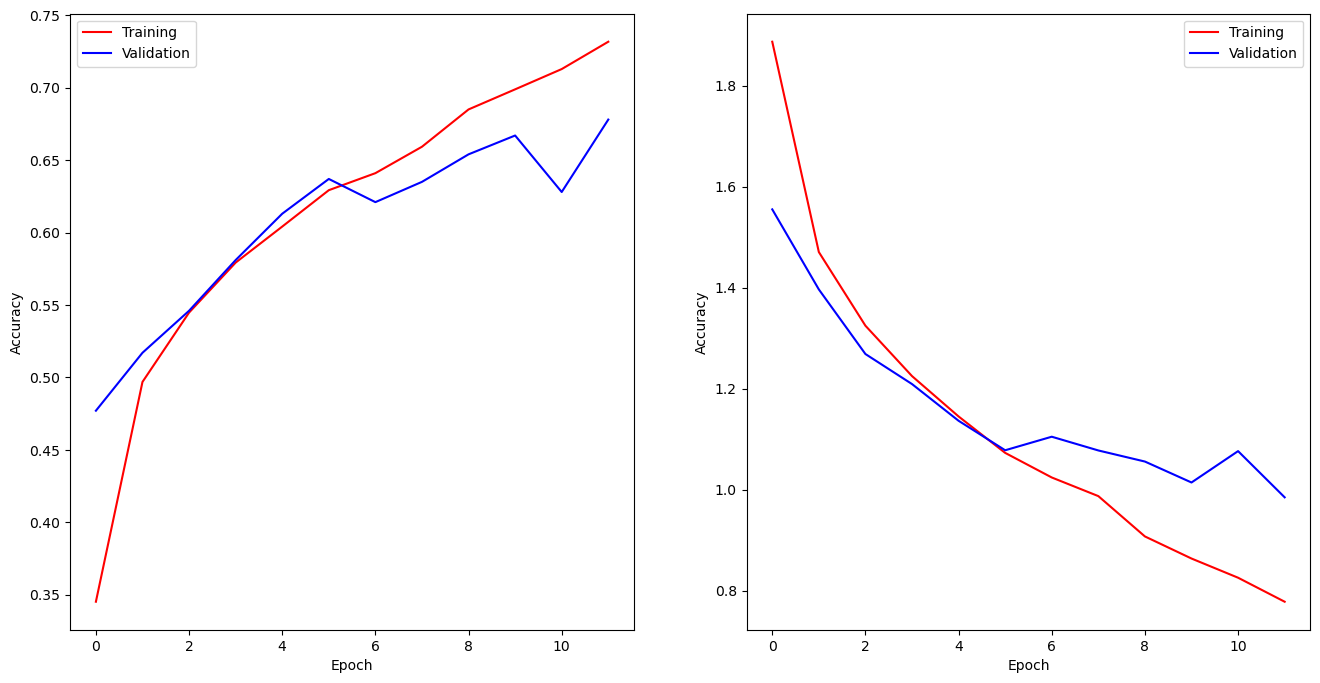

In [221]:
fix, ax = plt.subplots(figsize = (16,8), nrows = 1, ncols = 2)

ax[0].plot(hist["accuracy"], "r", label = "Training")
ax[0].plot(hist["val_accuracy"], "b", label = "Validation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(hist["loss"], "r", label = "Training")
ax[1].plot(hist["val_loss"], "b", label = "Validation")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.show()

In [222]:
test_loss, test_accuracy = cleaner_model.evaluate([test1_labels,test1_imgs], ytest1_labels) 

32/32 [==============================] - 0s 14ms/step - loss: 0.9356 - accuracy: 0.6820


In [223]:
start = time.time()
predicted_prob = cleaner_model.predict([noisy_labs,all_imgs])
predicted_labels = np.argmax(predicted_prob, axis = 1)
end = time.time()
print("Generating labels took " + str((end-start)/60) + " minutes")

1563/1563 [==============================] - 18s 12ms/step
Generating labels took 0.3711356321970622 minutes


In [225]:
predicted_labels[:40] #looks a little sus

array([5, 9, 9, 7, 9, 1, 6, 7, 8, 9, 4, 7, 9, 0, 9, 8, 9, 5, 3, 6, 0, 5,
       6, 6, 9, 9, 3, 5, 4, 9, 0, 9, 1, 5, 4, 7, 0, 7, 0, 0])

In [208]:
predicted_labels.shape

(50000,)

In [224]:
label_count = []
for i in range(9):
    label_count.append(np.count_nonzero(predicted_labels==i))
print(label_count)

[10057, 4133, 2013, 2102, 1363, 5067, 2259, 8697, 3996]


In [192]:
sum(predicted_labels[:10000]==clean_labels.to_numpy().flatten())

5367